# Investigate the time difference between the peak luminosity of the domiant quadrupole and the peak strain

#### Preliminaries

The investigation here assumes that the following flow of information is practical:
 1. An IMR signal is detected. PE is performed (not necessarily a full run) which results in posterior samples on intrensic parameters, and some extrensic ones. Of interest are samples in arrival time. 
 2. There are two advisable possibilties:
     * The posterior samples for time are used to derive the prior range in time used for the ringdowin PE
     * Similar to above, but only a lower-bound is derived
 3. The derivation in step above requires a known mapping between peak strain, and the reference time used in a ringdown model. For MMRDNS this reference time is defined relative to the peak luminosity of the leading quadrupole, so a map is needed between this quantity and the peak strain as IMR time samples are approximately the peak strain by definition.
 
#### Methods

Here we do the following:
 1. Load NR waveforms for nonspinning BBH systems
 2. Using the l=m=2 multipole, calculate the time of
     * peak strain
     * peak news (this has the same peak location as the luminosity)
 3. We inspect the difference of these peak times for varying mass ratios.
 
#### Results

The peak time in strain is found to differ from the peak luminosity location by a constant value of about $\langle t^{\mathrm{Peak}}_{\mathrm{News}} - t^{\mathrm{Peak}}_{\mathrm{Strain}} \rangle = 6.52 \pm 0.2352$ (M). This means that only a constant time shift need be applied for all nonspinning systems.

#### Discussion
The results of this study are confirmed for a number of test systems in which we compare NR, SEOBNRv2 and MMRDNS. Implication on PE should be considered. Namely translating IMR samples on time into a prior for ringdown PE. However this study does not necessarily illuminate the issue of how lalinference handles time-shift (it does this in the frequendy d)

## Setup Environment

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
# Import useful things
from os.path import isfile
# system('source ~/.virtual_enviroments/ringdownFD_nikhef/bin/activate')
from nrutils.core.basics import lalphenom
from kerr import rgb,gmvpfit,modelrd,anglep,qnmfit,leaver,ndflatten,sunwrap,alert,cyan,slm,ysprod,ssprod
from kerr.models import mmrdns
from kerr.models import mmrdnp
from nrutils import scsearch,gwylm,FinalSpin0815,EradRational0815,gwf
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
import corner
#
from numpy import *
from numpy.linalg import pinv
#
from nrutils.core.units import *
#
from scipy.optimize import minimize
from os.path import expanduser
#
import lal
from lal import MSUN_SI, PC_SI, C_SI, G_SI, MTSUN_SI
import lalsimulation as lalsim
alert('The LASIMULATION version is located at: %s'%( bold(yellow(lalsim.__path__[0])) ))
#
import review_ringdownFD_nikhef as review
from nrutils.analyze.match import match as match_object
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
plotdir = '/Users/book/KOALA/review_ringdownFD_nikhef/gallery/'
datadir = '/Users/book/KOALA/review_ringdownFD_nikhef/bin/'
datapath = datadir+'issue_7_samples.asc'

(<module>)>> The LASIMULATION version is located at: /Users/book/.virtual_enviroments/ringdownFD_nikhef/opt/lalsuite/lib/python2.7/site-packages/lalsimulation


## Select and NR Simulations

Note that here we apply the RIT remnant fits to the simulation metadata as BAM runs do not have reliable final mass and spin values from their post-processing.

In [2]:
# Find simlations to load 
# A = scsearch(keyword='q10c25e_T_112_448',verbose=True,nonspinning=True, apply_remnant_fit=True)
# A = scsearch(keyword='D11_q1.00_a0.0_m240',verbose=True)
# A = scsearch(keyword='q18a0a0c025_144',verbose=True, apply_remnant_fit=True )
# A = scsearch(keyword='q4a0_T_112_448',verbose=True, apply_remnant_fit=True)
# A = scsearch(institute='bam',nonspinning=True,verbose=True, apply_remnant_fit=True)
A = scsearch(keyword='hr',nonspinning=True,verbose=True)

(scsearch)>> Found keyword (='hr') keyword.
(scsearch)>> Found nonspinning (=True) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> Loading catalog information from:
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 83 possibly degenerate simulations:
[0001][bradwr] HRq-series: ns-q1.60	(D9_q1.6_a0.0_m160)
[0002][bradwr] HRq-series: ns-q1.40	(D9_q1.4_a0.0_m160)
[0003][bradwr] HRq-series: ns-q1.20	(D9_q1.2_a0.0_m160)
[0004][bradwr] HRq-series: ns-q1.10	(D9_q1.1_a0.0_m160)
[0005][bradwr] HRq-series: ns-q1.30	(D9_q1.3_a0.0_m160)
[0006][bradwr] HRq-series: ns-q1.50	(D9_q1.5_a0.0_m160)
[0007][bradwr] HRq-series: ns-q1.00	(D9_q1.0_a0.0_m160)
[0008][bradwr] HRq-series: ns-q4.50	(D9_q4.5_a0.0_m160)
[0009][bradwr] HRq-series: ns-q3.00	(D9_q3.0_a0.0_m160)
[0010][bradwr] HRq-series: ns-q2.90	(D9_q2.9_a0.0_m160)
[0011][brad

## Load simulation data

In [3]:
# Load simulation data
lmlist = []
for lm in [(2,2)]:
    l,m = lm; 
    lmlist+=[(l,m)]; 
    
    
#
newst = []
straint = []
eta = []
q = []

#
if isfile(datapath):
    data = loadtxt(datapath)
    q,eta,newst,straint = data[:,0],data[:,1],data[:,2],data[:,3]
    alert('We won\'t be collecting raw samples becuase they\'ve already been collected and saved.','notebook')
else:
    for a in A:
        alert(a.label)
        y = gwylm( a, lm=lmlist, clean=True )
        newst.append( y.lm[2,2]['news'].intrp_t_amp_max )
        straint.append( y.lm[2,2]['strain'].intrp_t_amp_max )
        eta.append( a.eta )
        q.append( a.m1/a.m2 )

(notebook)>> We won't be collecting raw samples becuase they've already been collected and saved.


## Plot Time Difference vs Eta

In [4]:
# Save samples for later use; do no save if files aready exist
if not isfile(datapath): 
    savetxt( datapath , array([q,eta,newst,straint]).T, header='q, eta, news_peak_time (M), strain_peak_time (M)' )
else:
    alert('We won\'t be saving the raw samples because they have apparently already been saved.','notebook')

(notebook)>> We won't be saving the raw samples because they have apparently already been saved.


/Library/Python/2.7/site-packages/matplotlib/lines.py:1082: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markeredgecolor != ec:


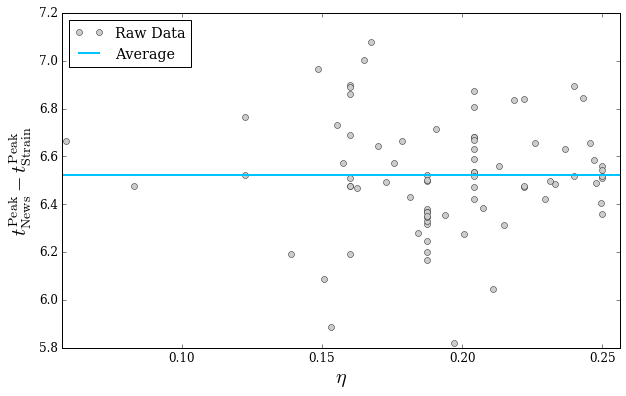

In [5]:

# One of the mass-ratio 7 data pionts is a bad simulation, so let's remove it
k = abs(array(q)-7)>1e-3
# Apply the mask defined above
newst_ = array(newst)[k]
straint_ = array(straint)[k]
eta_ = array(eta)[k]

# define a holder for the Difference in Peak Time (dpt)
dpt = newst_-straint_
adpt = average(dpt)

#
fig = figure( figsize = 2*array([5,3]) )
clr = rgb(3); grey = 0.8*ones(3)

# Plot the time difference between peak strain and peak luminosity
plot( eta_,dpt,'o', color=grey, mec = 0.2*grey, label='Raw Data' )
xlim( lim(eta_,dilate=0.025) )
# Since it looks like a constant + noise, let's also plot the average
axhline( adpt, color=clr[0], linewidth=2, label='Average' )

xlabel('$\eta$')
ylabel(r'$t^{\mathrm{Peak}}_{\mathrm{News}} - t^{\mathrm{Peak}}_{\mathrm{Strain}}$')
legend( frameon=not False,loc=2 )

# Save figure
figpath = plotdir+'issue_7_dPeakTime_on_Eta.pdf'
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )

## Plot Histogram of result

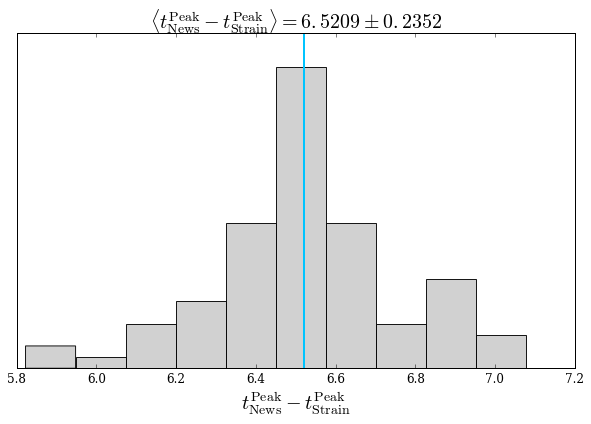

In [6]:
fig = figure( figsize = 2*array([5,3]) )
hist(dpt,color=grey,alpha=0.9)
axvline( adpt, color=clr[0],linewidth=2 )
xlabel(r'$t^{\mathrm{Peak}}_{\mathrm{News}} - t^{\mathrm{Peak}}_{\mathrm{Strain}}$')
title(r'$ \langle t^{\mathrm{Peak}}_{\mathrm{News}} - t^{\mathrm{Peak}}_{\mathrm{Strain}} \rangle = %1.4f \pm %1.4f $'%(adpt,std(dpt)) )
yticks([]);


# Save figure
figpath = plotdir+'issue_7_Histogram.pdf'
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )

## Use this information to plot NR, MMRDNS and a LAL TD Approximant

In [97]:
q_ = 1
A = scsearch(q=q_,keyword='hr',verbose=True,nonspinning=True)
y = gwylm(A[0],lm=(2,2),verbose=True,clean=True)

(scsearch)>> Found keyword (='hr') keyword.
(scsearch)>> Found nonspinning (=True) keyword.
(scsearch)>> Found q (=1) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> Loading catalog information from:
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 5 possibly degenerate simulations:
[0001][bradwr] HRq-series: ns-q1.00	(D9_q1.0_a0.0_m160)
[0002][bradwr] HR-series: ns-q1.00	(D11_q1.00_a0.0_m240)
[0003][bradwr] HR-series: ns-q1.00	(D11_q1.00_a0.0_m200)
[0004][bradwr] HR-series: ns-q1.00	(D11_q1.00_a0.0_m160)
[0005][bradwr] HR-series: ns-q1.00	(D11_q1.00_a0.0_m120)

(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.15) keyword.
(gwylm)>> Found lm (=(2, 2)) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x12c530518>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(valid

In [125]:
#
M_Sol = 70.0
D_Mpc = 400
dt_code = 0.5
dt = physt( y.dt, M_Sol )
fmin = 65.0
#
M = M_Sol*MSUN_SI
D = D_Mpc*1.0e6*PC_SI
#
m1_Sol = float(M_Sol)/(1+q_)
m2_Sol = q_*m1_Sol
#
m1,m2 = m1_Sol*MSUN_SI,m2_Sol*MSUN_SI
#
inclination,phi=0,0
# Generate an IMR TD waveform
hp_,hx_ = lalsim.SimInspiralChooseTDWaveform( m1,m2, 0,0,0, 0,0,0, D, inclination,phi, 0,0,0, dt, fmin, 0, None, lalsim.SEOBNRv2 )
hp = hp_.data.data; hx = hx_.data.data
h = hp + 1j*hx
t = hp_.deltaT * arange( 0, len(h) )
hlal = gwf( array([t,h.real,h.imag]).T, l=2,m=2, kind=r'$h_{\mathrm{LAL}}(\theta,\phi)$', m1=m1/M, m2=m2/M )
# Generate an instance of MMRDNS
hrd_ = lalsim.SimRingdownGenerateSphericalMultipoleMMRDNS_time(0, dt, M*y.mf, y.xf, y.eta, 2, 2, D, None, 500, 0 )
h = hrd_.data.data * sYlm(-2,2,2,inclination,phi)
# hp_,hx_ = lalsim.SimRingdownGenerateFullSphericalWaveform_time( 0, dt, 500, M*y.mf, y.xf, y.eta, inclination, phi, D, None )
# hp = hp_.data.data; hx = hx_.data.data
# h = hp + 1j*hx
t_rd_start = physt( 10 + adpt ,M_Sol) + hlal.intrp_t_amp_max 
trd = hrd_.deltaT * arange( 0, len(h) ) + t_rd_start
hrd = gwf( array([trd,h.real,h.imag]).T, l=2,m=2, kind=r'$h_{\mathrm{LAL}}(\theta,\phi)$', m1=m1/M, m2=m2/M )
hrd.shift_phase( -hrd.phi[0] + hnr.phi[ find(hnr.t>=t_rd_start)[0] ] + 0.52  )

(gwf.align!)>> No method chosen. We will proceed by aligning the waveform's initial phase.


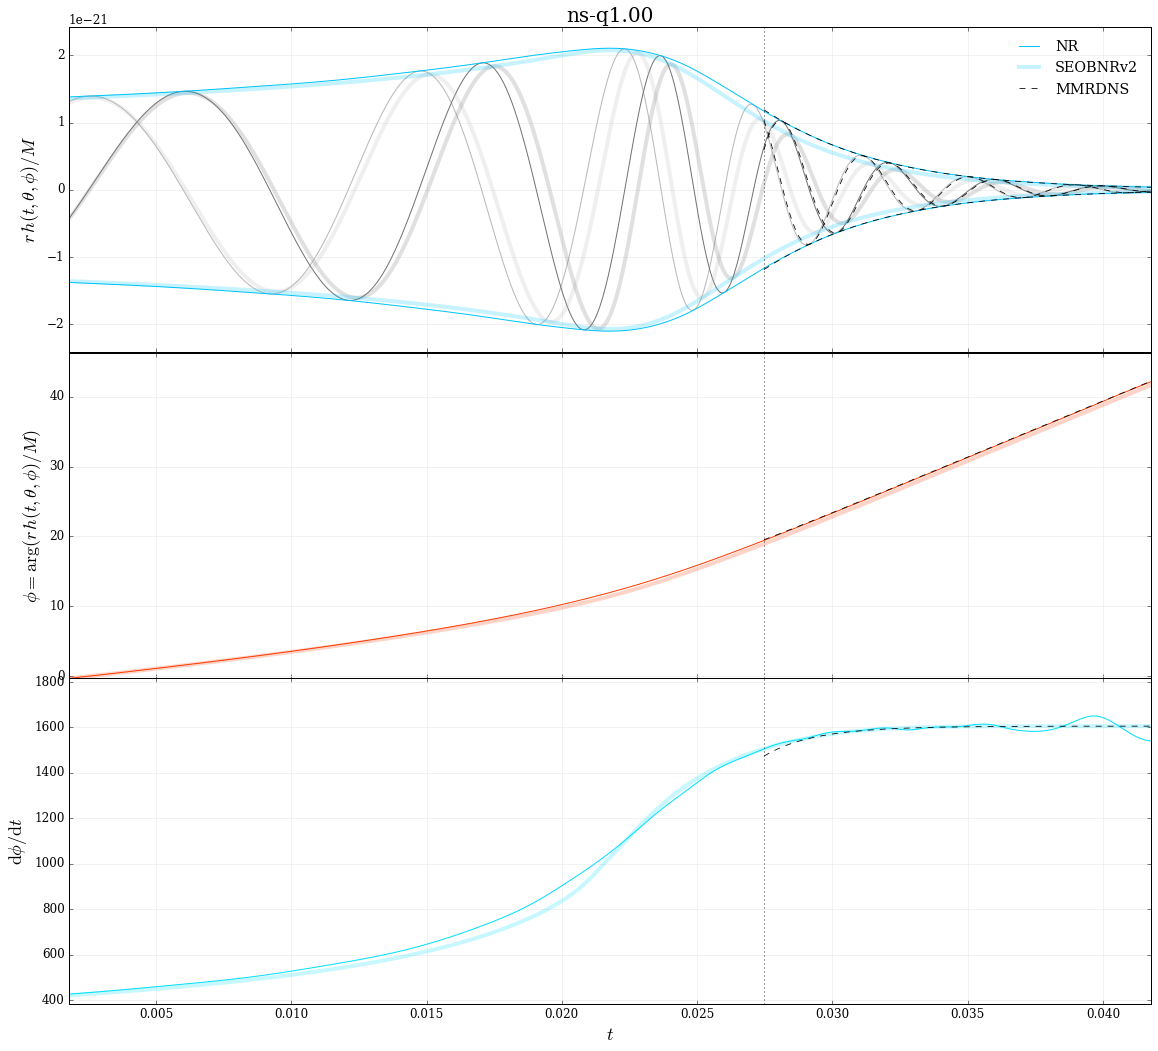

In [127]:
# Convert the NR waveform to physical units at optimal orientation
hnr = physh( y.recompose(inclination,phi,kind='strain',domain='time'), M_Sol, D_Mpc )
# Align the NR waveform's peak with the LAL waveform -- NOTE that this is independent of waveform length and sampling
hnr_ = hnr.tshift( -hnr.intrp_t_amp_max + hlal.intrp_t_amp_max )
# Phase align the waveforms
hnr_.align(hlal)
# Make a comparison plot
ax,fig = hnr_.plot( ref_gwf=hlal, labels=['NR','SEOBNRv2'], tlim=hlal.intrp_t_amp_max+0.02*array([-1,1]), sizescale=2 )
#
sca( ax[0] )
plot( trd, hrd.amp, '--k', label='MMRDNS' )
plot( trd,-hrd.amp, '--k' )
plot( trd, hrd.y.real, '--k' )
plot( trd, hrd.y.imag, '--k' )
axvline(t_rd_start, linestyle=':',color='k')
legend( frameon=False )
title(y.label)
#
sca( ax[1] )
plot( trd, hrd.phi - hrd.phi[0] + hlal.phi[ find(hlal.t>=t_rd_start)[0] ]+0.52, '--k', label='MMRDNS' )
axvline(t_rd_start, linestyle=':',color='k')
#
sca( ax[2] )
plot( trd, hrd.dphi, '--k', label='MMRDNS' )
axvline(t_rd_start, linestyle=':',color='k')

# Save figure
figpath = plotdir+'issue_7_practicum_q%1.2f.pdf'%q_
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )

In [109]:
400/(2*pi)

63.66197723675813